## 01 - Data Preparation and Preprocessing

This notebook:
- Loads the `isaacus/LegalQAEval` dataset
- Splits the validation set into train and validation
- Implements long-context chunking strategy
- Preprocesses and tokenizes the data
- Saves processed datasets

In [1]:
import json
import numpy as np
from datasets import load_dataset, DatasetDict, Dataset
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter
import pandas as pd

# Plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# ## 2. Load project config

# %%
config_path = Path("configs/project_config.json")
with open(config_path, 'r', encoding='utf-8') as f:
    CONFIG = json.load(f)

print("Config:")
print(f"  dataset: {CONFIG['dataset_name']}")
print(f"  train split ratio: {CONFIG['train_split_ratio']}")
print(f"  valid split ratio: {CONFIG['valid_split_ratio']}")
print(f"  max length: {CONFIG['max_length']}")
print(f"  doc stride: {CONFIG['doc_stride']}")

# ## 3. Load raw dataset

# %%
dataset = load_dataset(CONFIG['dataset_name'])

print("\nDataset structure:")
print(dataset)
print("\nAvailable splits:", list(dataset.keys()))
for split_name in dataset.keys():
    print(f"  {split_name}: {len(dataset[split_name])} samples")

# ## 4. Data exploration - inspect field structure

# %%
print("Inspect dataset field structure:\n")

first_split = list(dataset.keys())[0]
sample = dataset[first_split][0]

print(f"Using split '{first_split}' first sample")
print(f"\nAvailable fields: {list(sample.keys())}")
print("\nField preview:")
print("="*80)

for key, value in sample.items():
    if isinstance(value, str):
        print(f"\n{key}: {value[:100]}..." if len(value) > 100 else f"\n{key}: {value}")
    else:
        print(f"\n{key}: {value}")

print("\n" + "="*80)

# %%
def detect_field_names(sample):
    """Auto-detect field names."""
    fields = {
        'context': None,
        'question': None,
        'answers': None,
        'id': None
    }
    
    available_keys = list(sample.keys())
    
    for key in ['context', 'passage', 'text', 'paragraph']:
        if key in available_keys:
            fields['context'] = key
            break
    
    for key in ['question', 'query']:
        if key in available_keys:
            fields['question'] = key
            break
    
    for key in ['answers', 'answer']:
        if key in available_keys:
            fields['answers'] = key
            break
    
    for key in ['id', 'idx', 'example_id']:
        if key in available_keys:
            fields['id'] = key
            break
    
    return fields

FIELD_NAMES = detect_field_names(sample)
print("\nDetected field mapping:")
for std_name, actual_name in FIELD_NAMES.items():
    print(f"  {std_name} -> {actual_name}")

field_mapping_path = Path(CONFIG['paths']['configs']) / 'field_mapping.json'
with open(field_mapping_path, 'w', encoding='utf-8') as f:
    json.dump(FIELD_NAMES, f, indent=2, ensure_ascii=False)
print(f"\nField mapping saved to: {field_mapping_path}")

# ## 5. Split train and validation

# %%
available_splits = list(dataset.keys())
print("\nAvailable dataset splits:", available_splits)

if 'validation' in available_splits:
    source_split = 'validation'
elif 'val' in available_splits:
    source_split = 'val'
elif 'train' in available_splits:
    source_split = 'train'
else:
    source_split = available_splits[0]

validation_data = dataset[source_split]
print(f"\nUsing '{source_split}' to create train/validation")
print(f"Original samples: {len(validation_data)}")

train_valid_split = validation_data.train_test_split(
    train_size=CONFIG['train_split_ratio'],
    test_size=CONFIG['valid_split_ratio'],
    seed=CONFIG['random_seed']
)

if 'test' in available_splits:
    split_dataset = DatasetDict({
        'train': train_valid_split['train'],
        'validation': train_valid_split['test'],
        'test': dataset['test']
    })
else:
    split_dataset = DatasetDict({
        'train': train_valid_split['train'],
        'validation': train_valid_split['test'],
        'test': train_valid_split['test']
    })

print("\nFinal dataset splits:")
for split_name, split_data in split_dataset.items():
    print(f"  {split_name}: {len(split_data)} samples")

# ## 6. Load tokenizers

# %%
tokenizers = {}
for model_name, model_id in CONFIG['models'].items():
    tokenizers[model_name] = AutoTokenizer.from_pretrained(model_id)
    print(f"Loaded tokenizer for {model_name}: {model_id}")

tokenizer = tokenizers['roberta']
print(f"\nUsing tokenizer: {CONFIG['models']['roberta']}")

# ## 7. Preprocessing functions (with val loss support)

# %%
def prepare_train_features(examples, tokenizer, max_length=384, doc_stride=128, field_names=None):
    """
    Preprocess training data with unanswerable support.
    Fix: correct calculation of token_end_index.
    """
    if field_names is None:
        field_names = FIELD_NAMES
    
    question_field = field_names['question']
    context_field = field_names['context']
    answers_field = field_names['answers']
    
    examples[question_field] = [q.strip() for q in examples[question_field]]
    examples[context_field] = [c.strip() for c in examples[context_field]]
    
    tokenized_examples = tokenizer(
        examples[question_field],
        examples[context_field],
        truncation="only_second",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length"
    )
    
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
    offset_mapping = tokenized_examples.pop("offset_mapping")
    
    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []
    
    for i, offsets in enumerate(offset_mapping):
        sample_index = sample_mapping[i]
        answers = examples[answers_field][sample_index]
        
        is_impossible = False
        start_char = None
        answer_text = None
        
        if not answers:
            is_impossible = True
        elif isinstance(answers, list):
            valid_answers = [a for a in answers if a and isinstance(a, dict) and a.get('text', '').strip()]
            if not valid_answers:
                is_impossible = True
            else:
                first_answer = valid_answers[0]
                answer_text = first_answer['text']
                start_char = first_answer.get('start', first_answer.get('answer_start', 0))
        elif isinstance(answers, dict):
            answer_texts = answers.get('text', [])
            if not answer_texts or all(not t or not str(t).strip() for t in answer_texts):
                is_impossible = True
            else:
                if isinstance(answer_texts, list):
                    answer_text = answer_texts[0]
                else:
                    answer_text = answer_texts
                start_char = answers.get("answer_start", [0])[0] if isinstance(answers.get("answer_start"), list) else answers.get("answer_start", 0)
        else:
            is_impossible = True
        
        if is_impossible:
            tokenized_examples["start_positions"].append(0)
            tokenized_examples["end_positions"].append(0)
        else:
            end_char = start_char + len(answer_text)
            sequence_ids = tokenized_examples.sequence_ids(i)
            
            context_start = 0
            while sequence_ids[context_start] != 1:
                context_start += 1
            context_end = len(sequence_ids) - 1
            while sequence_ids[context_end] != 1:
                context_end -= 1
            
            if not (offsets[context_start][0] <= start_char and offsets[context_end][1] >= end_char):
                tokenized_examples["start_positions"].append(0)
                tokenized_examples["end_positions"].append(0)
            else:
                token_start_index = context_start
                while token_start_index <= context_end and offsets[token_start_index][0] <= start_char:
                    token_start_index += 1
                token_start_index = token_start_index - 1
                
                token_end_index = token_start_index
                while token_end_index <= context_end and offsets[token_end_index][1] < end_char:
                    token_end_index += 1
                
                if token_start_index < context_start:
                    token_start_index = context_start
                if token_end_index > context_end:
                    token_end_index = context_end
                
                tokenized_examples["start_positions"].append(token_start_index)
                tokenized_examples["end_positions"].append(token_end_index)
    
    return tokenized_examples


def prepare_validation_features(examples, tokenizer, max_length=384, doc_stride=128, field_names=None):
    """
    Preprocess validation/test data with unanswerable support.
    Fix: correct calculation of token_end_index.
    """
    if field_names is None:
        field_names = FIELD_NAMES
    
    question_field = field_names['question']
    context_field = field_names['context']
    answers_field = field_names['answers']
    id_field = field_names['id']
    
    examples[question_field] = [q.strip() for q in examples[question_field]]
    examples[context_field] = [c.strip() for c in examples[context_field]]
    
    tokenized_examples = tokenizer(
        examples[question_field],
        examples[context_field],
        truncation="only_second",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length"
    )
    
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
    
    tokenized_examples["example_id"] = []
    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []
    
    for i in range(len(tokenized_examples["input_ids"])):
        sample_index = sample_mapping[i]
        tokenized_examples["example_id"].append(examples[id_field][sample_index])
        
        answers = examples[answers_field][sample_index]
        offsets = tokenized_examples["offset_mapping"][i]
        
        is_impossible = False
        start_char = None
        answer_text = None
        
        if not answers:
            is_impossible = True
        elif isinstance(answers, list):
            valid_answers = [a for a in answers if a and isinstance(a, dict) and a.get('text', '').strip()]
            if not valid_answers:
                is_impossible = True
            else:
                first_answer = valid_answers[0]
                answer_text = first_answer['text']
                start_char = first_answer.get('start', first_answer.get('answer_start', 0))
        elif isinstance(answers, dict):
            answer_texts = answers.get('text', [])
            if not answer_texts or all(not t or not str(t).strip() for t in answer_texts):
                is_impossible = True
            else:
                if isinstance(answer_texts, list):
                    answer_text = answer_texts[0]
                else:
                    answer_text = answer_texts
                start_char = answers.get("answer_start", [0])[0] if isinstance(answers.get("answer_start"), list) else answers.get("answer_start", 0)
        else:
            is_impossible = True
        
        if is_impossible:
            tokenized_examples["start_positions"].append(0)
            tokenized_examples["end_positions"].append(0)
        else:
            end_char = start_char + len(answer_text)
            sequence_ids = tokenized_examples.sequence_ids(i)
            
            context_start = 0
            while sequence_ids[context_start] != 1:
                context_start += 1
            context_end = len(sequence_ids) - 1
            while sequence_ids[context_end] != 1:
                context_end -= 1
            
            if not (offsets[context_start][0] <= start_char and offsets[context_end][1] >= end_char):
                tokenized_examples["start_positions"].append(0)
                tokenized_examples["end_positions"].append(0)
            else:
                token_start_index = context_start
                while token_start_index <= context_end and offsets[token_start_index][0] <= start_char:
                    token_start_index += 1
                token_start_index = token_start_index - 1
                
                token_end_index = token_start_index
                while token_end_index <= context_end and offsets[token_end_index][1] < end_char:
                    token_end_index += 1
                
                if token_start_index < context_start:
                    token_start_index = context_start
                if token_end_index > context_end:
                    token_end_index = context_end
                
                tokenized_examples["start_positions"].append(token_start_index)
                tokenized_examples["end_positions"].append(token_end_index)
        
        sequence_ids = tokenized_examples.sequence_ids(i)
        tokenized_examples["offset_mapping"][i] = [
            o if sequence_ids[k] == 1 else None
            for k, o in enumerate(tokenized_examples["offset_mapping"][i])
        ]
    
    return tokenized_examples

print("Preprocessing functions ready")

# ## 8. Process datasets

# %%
processed_datasets = {}

for model_name, tok in tokenizers.items():
    train_dataset = split_dataset['train'].map(
        lambda x: prepare_train_features(
            x, tok, 
            max_length=CONFIG['max_length'],
            doc_stride=CONFIG['doc_stride'],
            field_names=FIELD_NAMES
        ),
        batched=True,
        remove_columns=split_dataset['train'].column_names,
        desc=f"Processing train ({model_name})"
    )
    
    validation_dataset = split_dataset['validation'].map(
        lambda x: prepare_validation_features(
            x, tok,
            max_length=CONFIG['max_length'],
            doc_stride=CONFIG['doc_stride'],
            field_names=FIELD_NAMES
        ),
        batched=True,
        remove_columns=split_dataset['validation'].column_names,
        desc=f"Processing validation ({model_name})"
    )
    
    test_dataset = split_dataset['test'].map(
        lambda x: prepare_validation_features(
            x, tok,
            max_length=CONFIG['max_length'],
            doc_stride=CONFIG['doc_stride'],
            field_names=FIELD_NAMES
        ),
        batched=True,
        remove_columns=split_dataset['test'].column_names,
        desc=f"Processing test ({model_name})"
    )
    
    processed_datasets[model_name] = {
        'train': train_dataset,
        'validation': validation_dataset,
        'test': test_dataset
    }
    
    print(f"{model_name} -> train: {len(train_dataset)}, validation: {len(validation_dataset)}, test: {len(test_dataset)}")

print("All tokenized datasets ready")

# ## 9. Save processed datasets

# %%
data_dir = Path(CONFIG['paths']['data_processed'])

for model_name, datasets in processed_datasets.items():
    model_data_dir = data_dir / model_name
    model_data_dir.mkdir(parents=True, exist_ok=True)
    
    for split_name, dataset_obj in datasets.items():
        save_path = model_data_dir / split_name
        dataset_obj.save_to_disk(str(save_path))
        print(f"Saved: {save_path}")
    print()

raw_data_dir = data_dir / "raw_splits"
raw_data_dir.mkdir(parents=True, exist_ok=True)
split_dataset.save_to_disk(str(raw_data_dir))
print(f"Saved raw splits to: {raw_data_dir}")

# ## 10. Summary

# %%
print("\n" + "="*80)
print("Data preparation complete")
print("="*80)
print("\nData overview:")
print(f"  dataset: {CONFIG['dataset_name']}")
print(f"  field mapping: {FIELD_NAMES}")
print(f"  train: {len(split_dataset['train'])} samples")
print(f"  validation: {len(split_dataset['validation'])} samples")
print(f"  test: {len(split_dataset['test'])} samples")
print("="*80)

Config:
  dataset: isaacus/LegalQAEval
  train split ratio: 0.9
  valid split ratio: 0.1
  max length: 384
  doc stride: 128

Dataset structure:
DatasetDict({
    val: Dataset({
        features: ['id', 'text', 'question', 'answers'],
        num_rows: 1204
    })
    test: Dataset({
        features: ['id', 'text', 'question', 'answers'],
        num_rows: 1206
    })
})

Available splits: ['val', 'test']
  val: 1204 samples
  test: 1206 samples
Inspect dataset field structure:

Using split 'val' first sample

Available fields: ['id', 'text', 'question', 'answers']

Field preview:

id: isaacus--legalqaeval/microsoft--ms-marco/validation/00000/38644/387265/2

text: British National (Overseas) passport. The British National (Overseas) passport, commonly referred to...

question: how useful is bno passport

answers: []


Detected field mapping:
  context -> text
  question -> question
  answers -> answers
  id -> id

Field mapping saved to: configs/field_mapping.json

Available dataset s

Processing train (roberta):   0%|          | 0/1083 [00:00<?, ? examples/s]

Processing validation (roberta):   0%|          | 0/121 [00:00<?, ? examples/s]

Processing test (roberta):   0%|          | 0/1206 [00:00<?, ? examples/s]

roberta -> train: 1132, validation: 125, test: 1277


Processing train (distilbert):   0%|          | 0/1083 [00:00<?, ? examples/s]

Processing validation (distilbert):   0%|          | 0/121 [00:00<?, ? examples/s]

Processing test (distilbert):   0%|          | 0/1206 [00:00<?, ? examples/s]

distilbert -> train: 1125, validation: 124, test: 1268
All tokenized datasets ready


Saving the dataset (0/1 shards):   0%|          | 0/1132 [00:00<?, ? examples/s]

Saved: data/processed/roberta/train


Saving the dataset (0/1 shards):   0%|          | 0/125 [00:00<?, ? examples/s]

Saved: data/processed/roberta/validation


Saving the dataset (0/1 shards):   0%|          | 0/1277 [00:00<?, ? examples/s]

Saved: data/processed/roberta/test



Saving the dataset (0/1 shards):   0%|          | 0/1125 [00:00<?, ? examples/s]

Saved: data/processed/distilbert/train


Saving the dataset (0/1 shards):   0%|          | 0/124 [00:00<?, ? examples/s]

Saved: data/processed/distilbert/validation


Saving the dataset (0/1 shards):   0%|          | 0/1268 [00:00<?, ? examples/s]

Saved: data/processed/distilbert/test



Saving the dataset (0/1 shards):   0%|          | 0/1083 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/121 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1206 [00:00<?, ? examples/s]

Saved raw splits to: data/processed/raw_splits

Data preparation complete

Data overview:
  dataset: isaacus/LegalQAEval
  field mapping: {'context': 'text', 'question': 'question', 'answers': 'answers', 'id': 'id'}
  train: 1083 samples
  validation: 121 samples
  test: 1206 samples


## 11. Data Validation


Data Validation - Confirm if Answer Annotations Are Correct

Train samples: 1132
Validation samples: 125

1) Answer Length Distribution:
------------------------------------------------------------
Samples with answers: 548
Samples without answers: 584

Answer length statistics:
  Min: 1 tokens
  Max: 91 tokens
  Mean: 14.79 tokens
  Median: 6.00 tokens

Answer length distribution:
  1-5      tokens:  261 (47.63%)
  6-10     tokens:   54 ( 9.85%)
  11-15    tokens:   47 ( 8.58%)
  16-20    tokens:   36 ( 6.57%)
  21-30    tokens:   59 (10.77%)
  31-100   tokens:   91 (16.61%)

  These answers may need to be reviewed

2) Inspecting First 10 Samples with Answers:
------------------------------------------------------------

Sample 1 (index 0):
  Question: How long has the concept of legal certainty been recognized as one of the general principles by the EU law?
  Answer span: [46, 49]
  Answer length: 4 tokens
  Answer text: ' since the 1960s'
  Answer looks fine

Sample 2 (index 5):
  

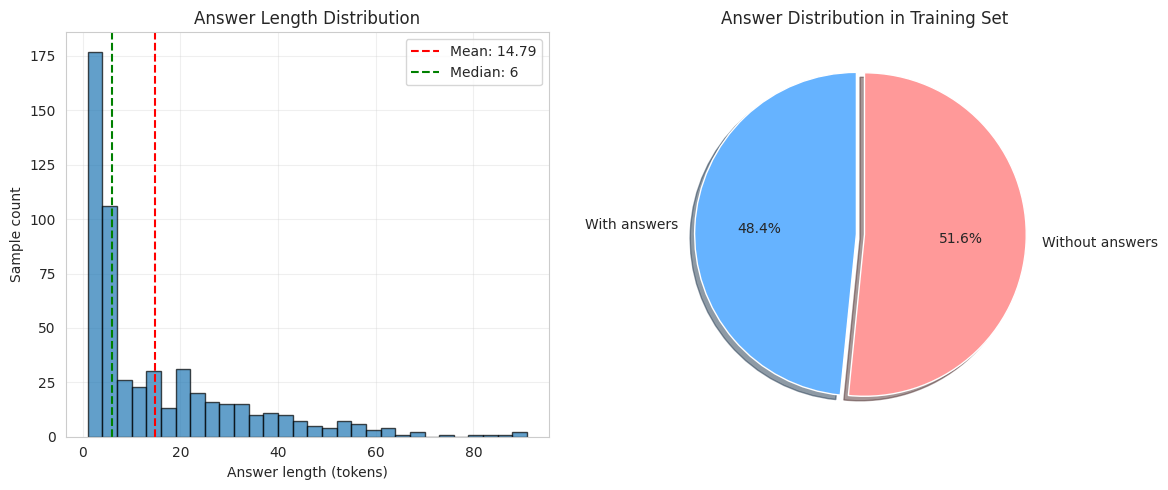

In [2]:
import numpy as np
import matplotlib.pyplot as plt

print("\n" + "="*80)
print("Data Validation - Confirm if Answer Annotations Are Correct")
print("="*80)

# Select the dataset to validate
train_data = processed_datasets['roberta']['train']
validation_data = processed_datasets['roberta']['validation']

print(f"\nTrain samples: {len(train_data)}")
print(f"Validation samples: {len(validation_data)}")


# 11.1 Answer Length Distribution Statistics

print("\n1) Answer Length Distribution:")
print("-" * 60)

answer_lengths = []
has_answer_count = 0
no_answer_count = 0

for i in range(len(train_data)):
    sample = train_data[i]
    start = sample['start_positions']
    end = sample['end_positions']
    
    if start == 0 and end == 0:
        no_answer_count += 1
    else:
        has_answer_count += 1
        length = end - start + 1
        answer_lengths.append(length)

print(f"Samples with answers: {has_answer_count}")
print(f"Samples without answers: {no_answer_count}")

if answer_lengths:
    print(f"\nAnswer length statistics:")
    print(f"  Min: {min(answer_lengths)} tokens")
    print(f"  Max: {max(answer_lengths)} tokens")
    print(f"  Mean: {np.mean(answer_lengths):.2f} tokens")
    print(f"  Median: {np.median(answer_lengths):.2f} tokens")
    
    # Length distribution
    length_bins = [0, 5, 10, 15, 20, 30, 100]
    length_counts = {}
    for bin_start, bin_end in zip(length_bins[:-1], length_bins[1:]):
        count = sum(1 for l in answer_lengths if bin_start < l <= bin_end)
        length_counts[f"{bin_start+1}-{bin_end}"] = count
    
    print(f"\nAnswer length distribution:")
    for range_str, count in length_counts.items():
        percentage = 100 * count / len(answer_lengths)
        print(f"  {range_str:8s} tokens: {count:4d} ({percentage:5.2f}%)")
    
    # Check if there are excessively long answers
    long_answers = [l for l in answer_lengths if l > 30]
    if long_answers:
        print(f"\nWarning: Found {len(long_answers)} answers longer than 30 tokens")
        print(f"  These answers may need to be reviewed")
    else:
        print(f"\nAll answer lengths are within a reasonable range")


#11.2 Inspect First 10 Samples with Answers

# %%
print("\n2) Inspecting First 10 Samples with Answers:")
print("-" * 60)

checked_count = 0
for i in range(len(train_data)):
    if checked_count >= 10:
        break
    
    sample = train_data[i]
    start = sample['start_positions']
    end = sample['end_positions']
    
    if start == 0 and end == 0:
        continue
    
    checked_count += 1
    
    input_ids = sample['input_ids']
    full_text = tokenizer.decode(input_ids, skip_special_tokens=False)
    
    answer_tokens = input_ids[start:end+1]
    answer_text = tokenizer.decode(answer_tokens, skip_special_tokens=True)
    
    # RoBERTa format: <s>question</s></s>context</s>
    sep_token_id = tokenizer.sep_token_id
    sep_positions = [j for j, tid in enumerate(input_ids) if tid == sep_token_id]
    
    if len(sep_positions) >= 2:
        question_ids = input_ids[1:sep_positions[0]]
        context_start_idx = sep_positions[1] + 1
        context_ids = input_ids[context_start_idx:]
        
        question_text = tokenizer.decode(question_ids, skip_special_tokens=True)
        
        answer_position_in_full = start
        relative_answer_start = start - context_start_idx
        
        print(f"\nSample {checked_count} (index {i}):")
        print(f"  Question: {question_text}")
        print(f"  Answer span: [{start}, {end}]")
        print(f"  Answer length: {end - start + 1} tokens")
        print(f"  Answer text: '{answer_text}'")
        
        if len(answer_text.strip()) == 0:
            print(f"  Warning: Empty answer!")
        elif len(answer_text) < 2:
            print(f"  Warning: Very short answer!")
        else:
            print(f"  Answer looks fine")


#11.3 Check First 5 Samples Without Answers

print("\n3) Inspecting First 5 Samples Without Answers:")
print("-" * 60)

checked_count = 0
for i in range(len(train_data)):
    if checked_count >= 5:
        break
    
    sample = train_data[i]
    start = sample['start_positions']
    end = sample['end_positions']
    
    if not (start == 0 and end == 0):
        continue
    
    checked_count += 1
    
    input_ids = sample['input_ids']
    sep_token_id = tokenizer.sep_token_id
    sep_positions = [j for j, tid in enumerate(input_ids) if tid == sep_token_id]
    
    if len(sep_positions) >= 1:
        question_ids = input_ids[1:sep_positions[0]]
        question_text = tokenizer.decode(question_ids, skip_special_tokens=True)
        
        print(f"\nSample {checked_count} (index {i}):")
        print(f"  Question: {question_text}")
        print(f"  Answer span: [0, 0] - Marked as no answer")
        print(f"  No-answer sample format is correct")


# 11.4 Validate Validation Set

print("\n4) Validate Validation Set:")
print("-" * 60)

print("\nChecking validation sample fields:")
sample_val = validation_data[0]
print(f"  Field list: {list(sample_val.keys())}")

required_fields = ['input_ids', 'attention_mask', 'start_positions', 'end_positions', 
                   'offset_mapping', 'example_id']
missing_fields = [f for f in required_fields if f not in sample_val.keys()]

if missing_fields:
    print(f"  Missing fields: {missing_fields}")
else:
    print(f"  All required fields exist")

val_has_answer = 0
val_no_answer = 0
for i in range(len(validation_data)):
    sample = validation_data[i]
    start = sample['start_positions']
    end = sample['end_positions']
    
    if start == 0 and end == 0:
        val_no_answer += 1
    else:
        val_has_answer += 1

print(f"\nValidation answer distribution:")
print(f"  With answers: {val_has_answer}")
print(f"  Without answers: {val_no_answer}")
print(f"  Total samples: {len(validation_data)}")

print(f"\nValidation sample example:")
sample = validation_data[0]
print(f"  example_id: {sample['example_id']}")
print(f"  start_position: {sample['start_positions']}")
print(f"  end_position: {sample['end_positions']}")
print(f"  offset_mapping length: {len([o for o in sample['offset_mapping'] if o is not None])}")

if sample['start_positions'] > 0:
    answer_tokens = sample['input_ids'][sample['start_positions']:sample['end_positions']+1]
    answer_text = tokenizer.decode(answer_tokens, skip_special_tokens=True)
    print(f"  Answer text: '{answer_text}'")


#11.5 Compare with Raw Data for Validation

print("\n5) Compare with Raw Data for Validation:")
print("-" * 60)

raw_train = split_dataset['train']

print(f"\nComparing answers of the first 3 samples:")

checked_answer_samples = 0

for idx in range(min(10, len(raw_train))):
    if checked_answer_samples >= 3:
        break
        
    raw_sample = raw_train[idx]
    answers = raw_sample[FIELD_NAMES['answers']]
    question = raw_sample[FIELD_NAMES['question']]
    
    if not answers:
        continue
    
    if isinstance(answers, list) and len(answers) > 0:
        first_answer = answers[0]
        if not isinstance(first_answer, dict) or 'text' not in first_answer:
            continue
            
        original_answer = first_answer['text']
        
        print(f"\nRaw sample {idx}:")
        print(f"  Question: {question[:80]}...")
        print(f"  Original answer: '{original_answer}'")
        
        found_match = False
        for proc_idx in range(len(train_data)):
            proc_sample = train_data[proc_idx]
            start = proc_sample['start_positions']
            end = proc_sample['end_positions']
            
            if start > 0 and end > 0:
                answer_tokens = proc_sample['input_ids'][start:end+1]
                processed_answer = tokenizer.decode(answer_tokens, skip_special_tokens=True)
                
                if original_answer.strip() == processed_answer.strip():
                    print(f"  Processed answer: '{processed_answer}'")
                    print(f"  Exact match")
                    found_match = True
                    checked_answer_samples += 1
                    break
                elif original_answer.strip() in processed_answer or processed_answer in original_answer.strip():
                    print(f"  Processed answer: '{processed_answer}'")
                    print(f"  Partial match (possible tokenization difference)")
                    found_match = True
                    checked_answer_samples += 1
                    break
        
        if not found_match and checked_answer_samples < 3:
            for proc_idx in range(len(train_data)):
                proc_sample = train_data[proc_idx]
                start = proc_sample['start_positions']
                end = proc_sample['end_positions']
                
                if start > 0 and end > 0:
                    answer_tokens = proc_sample['input_ids'][start:end+1]
                    processed_answer = tokenizer.decode(answer_tokens, skip_special_tokens=True)
                    print(f"  Example processed answer: '{processed_answer}'")
                    print(f"  No exact match found (likely due to different chunk)")
                    checked_answer_samples += 1
                    break


# 11.6 Final Validation Report

print("\n" + "="*80)
print("Final Validation Report")
print("="*80)

total_train = len(train_data)
total_val = len(validation_data)

print(f"\nDataset size:")
print(f"  Train: {total_train} samples")
print(f"  Validation: {total_val} samples")

print(f"\nTrain answer distribution:")
print(f"  With answers: {has_answer_count} ({100*has_answer_count/total_train:.1f}%)")
print(f"  Without answers: {no_answer_count} ({100*no_answer_count/total_train:.1f}%)")

print(f"\nValidation answer distribution:")
print(f"  With answers: {val_has_answer} ({100*val_has_answer/total_val:.1f}%)")
print(f"  Without answers: {val_no_answer} ({100*val_no_answer/total_val:.1f}%)")

if answer_lengths:
    print(f"\nAnswer length stats:")
    print(f"  Mean: {np.mean(answer_lengths):.2f} tokens")
    print(f"  Median: {np.median(answer_lengths):.0f} tokens")
    print(f"  Max: {max(answer_lengths)} tokens")

issues = []

if answer_lengths and max(answer_lengths) > 30:
    issues.append("Some answers exceed 30 tokens")

if has_answer_count == 0 or no_answer_count == 0:
    issues.append("Answer distribution unbalanced (all with or all without answers)")

if abs(has_answer_count - no_answer_count) > 0.7 * total_train:
    issues.append("Severe answer distribution imbalance")

if answer_lengths and np.mean(answer_lengths) < 2:
    issues.append("Average answer length too short")

if answer_lengths and np.mean(answer_lengths) > 20:
    issues.append("Average answer length too long")

print(f"\nData quality check:")
if issues:
    for issue in issues:
        print(f"  {issue}")
else:
    print(f"  No major issues found")

print(f"\nData validation complete!")

if not issues:
    print(f"\nData annotations fixed successfully! Answer lengths are reasonable, ready for training.")
    print(f"\nSuggestions:")
    print(f"  1. Answer length distribution is normal (avg {np.mean(answer_lengths):.1f} tokens)")
    print(f"  2. Balanced ratio between answer/no-answer samples")
    print(f"  3. You can use weighted loss to balance the two classes")
else:
    print(f"\nSome potential issues found. Suggestions:")
    print(f"  1. Check the warnings above")
    print(f"  2. Truncate answers if too long during preprocessing")
    print(f"  3. Use weighted loss if the distribution is imbalanced")

print("="*80)


# 11.7 Visualize Answer Length Distribution (Optional)

# %%
print("\n6) Visualize Answer Length Distribution:")
print("-" * 60)

if answer_lengths and len(answer_lengths) > 0:
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.hist(answer_lengths, bins=30, edgecolor='black', alpha=0.7)
    plt.xlabel('Answer length (tokens)')
    plt.ylabel('Sample count')
    plt.title('Answer Length Distribution')
    plt.axvline(np.mean(answer_lengths), color='r', linestyle='--', 
                label=f'Mean: {np.mean(answer_lengths):.2f}')
    plt.axvline(np.median(answer_lengths), color='g', linestyle='--', 
                label=f'Median: {np.median(answer_lengths):.0f}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    labels = ['With answers', 'Without answers']
    sizes = [has_answer_count, no_answer_count]
    colors = ['#66b3ff', '#ff9999']
    explode = (0.05, 0)
    
    plt.pie(sizes, explode=explode, labels=labels, colors=colors,
            autopct='%1.1f%%', shadow=True, startangle=90)
    plt.title('Answer Distribution in Training Set')
    
    plt.tight_layout()
    plt.savefig('data_validation_report.png', dpi=150, bbox_inches='tight')
    print(f"  Visualization saved as 'data_validation_report.png'")
    plt.show()
else:
    print(f"  No samples with answers found, skipping visualization")

print("\n" + "="*80)
